In [1]:
# Numpy
import numpy as np
from numpy import array

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances

# scipy
import scipy as sp
import scipy.stats
import scipy.sparse as sps
from scipy import spatial
from scipy.sparse import coo_matrix
# nltk
from nltk import cluster
from nltk.cluster import cosine_distance

# Others
import os 
import pandas as pd
from copy import copy,deepcopy
import time
from math import exp,log
import operator
from heapq import heappush, heappop, nlargest
import numpy as np
from operator import add

# 1. Obtain Data

## 1.1Taxi Data

In [2]:
#######################################
#load and process data
#######################################
def adjacent_point(start_state,direction,num_of_state,num_of_grid):
    '''Associate the direction of the points in map with states-number. 
    For example, state + 20 gives the right-point to the current states.
    '''
    start_point_row = start_state//num_of_grid
    start_point_col = start_state%num_of_grid
    if (direction == 0):
        next_state = (start_point_row*num_of_grid+start_point_col)
    elif (direction == 1):
        next_state = (start_point_row-1)*num_of_grid+start_point_col-1
    elif (direction == 2): 
        next_state = (start_point_row*num_of_grid+start_point_col-1)
    elif (direction == 3):
        next_state = (start_point_row+1)*num_of_grid+start_point_col-1
    elif (direction == 4):
        next_state = (start_point_row-1)*num_of_grid+start_point_col
    elif (direction == 5):
        next_state = (start_point_row+1)*num_of_grid+start_point_col
    elif (direction == 6):
        next_state = (start_point_row-1)*num_of_grid+start_point_col+1
    elif (direction == 7):
        next_state = start_point_row*num_of_grid+(start_point_col+1)
    elif (direction == 8):
        next_state = (start_point_row+1)*num_of_grid+ start_point_col+1

    return next_state


def load_and_clean_taxi_data(filename,num_of_data):
    '''Input: Filename about Taxi Data you want to load ***in the same directory*** and num_of_data you want to import
    Output: A list whose elements are taxi trajectories in a 20X20 grid
    '''
    data = pd.read_csv(filename,nrows=num_of_data, header=None) # In total : 1710670 data point
    # Delete useless information other than trajectories
    res = data[8]
    del res[0]
    
    # Data cleaining: convert pair-wise trajectories to separate row and column representation
    trajectory = []
    temp = []
    final_res = []
    test_res = []
    for i in range(len(res)):
        #get the string version of each trajectory
        trajectory.append(res[i+1].split(',')) 
    
    for i in range(len(trajectory)):
            # delete redundent data
            if len(trajectory[i]) > 1 :
                for j in range(len(trajectory[i])):
                    #remove  '[' and ']'
                    temp1 = trajectory[i][j].replace(']','')
                    temp2 = temp1.replace('[','')
                    trajectory[i][j] = float(temp2)

    # Delete empty element
    unwanted = []
    for i in range(len(trajectory)):
        if trajectory[i] == ['[]']:
            unwanted.append(i)
    trajectory = [j for i,j in enumerate(trajectory) if i not in unwanted]
    
    # Separate longitude and latitude for graph
    longitude = [1]*(len(trajectory))
    latitude = [1]*(len(trajectory))
    for i in range(len(trajectory)):
        longitude[i] = trajectory[i][::2]
        latitude[i] = trajectory[i][1::2]

    ######################################################
    # Limit the range of the data
    bound_left = -8.692
    bound_right = -8.56
    bound_up = 41.200
    bound_down = 41.125
    
    # Mark the unwanted element/trajectories from the original list
    unwanted = []
    for i in range(len(trajectory)):
        for j in range(len(longitude[i])):
            ##if its not in the range
            if (longitude[i][j]>bound_right) or (longitude[i][j]<bound_left):
                unwanted.append(i)
                break
            elif (latitude[i][j]>bound_up) or (latitude[i][j]<bound_down):
                unwanted.append(i)
                break

    # Delete unwanted element from the list 
    longitude_bound = [j for i,j in enumerate(longitude) if i not in unwanted]
    latitude_bound = [j for i,j in enumerate(latitude) if i not in unwanted]

    # Refresh the trajecotory  
    final_res_new = [j for i,j in enumerate(trajectory) if i not in unwanted]

    ###################################################
    ##set grid
    num_grid_row = 20
    num_grid_col = 20

    len_grid_row = (bound_right - bound_left)/num_grid_row
    len_grid_col = (bound_up - bound_down)/num_grid_col
    
    row_index = []
    col_index = []
    row_index_temp1 = []
    col_index_temp1 = []
    
    for i in range(len(final_res_new)):
        for j in range(len(latitude_bound[i])):
            # Store every grid-trajectory into temp variable
            row_index_temp = int((longitude_bound[i][j] - bound_left)//len_grid_row)
            col_index_temp = int((latitude_bound[i][j] - bound_down)//len_grid_col)
            row_index_temp1.append(row_index_temp)
            col_index_temp1.append(col_index_temp)
        # Store every grid-trajectory into the nested list containing all trajectories
        row_index.append(row_index_temp1)
        col_index.append(col_index_temp1)
        row_index_temp1 = []
        col_index_temp1 = []
        
    # Convert from row and column index to state number between 0 - 399
    output_data = []
    for i in range(len(row_index)):
        temp = []
        for j in range(len(row_index[i])):
            state_index = row_index[i][j]*num_grid_row+col_index[i][j]
            adjacent_state
            temp.append(state_index)
        if(2<len(temp)<100): # Remove all trajectories with length > 100
            output_data.append(temp)
    return output_data

## 1.2 Synthetic Dataset

In [3]:
def add_next_state_without_loop(output_data,current_state,next_state_prob,grid_num,state_num):
    '''In the navigation domain,
    Input the existing trajectory,current state, 
    create a next_state given the next_state_probability, without creating a loop'''
    
    c_row = current_state//grid_num # Current state row index
    c_col = current_state%grid_num # Current state col index
    
    # While flag == 0, keep on creating next_state untill meet requirements.
    flag = 0
    while(flag == 0):
        
        n_row = c_row
        n_col = c_col
        # Get the next_state direction compared to current state from the next_state_probability distribution
        next_state_direction = np.argmax(np.random.multinomial(1, next_state_prob, size=1))
        
        # Define direction 
        # 0:Upper-left, 1:Up 2:Upper-right 3:left 4:stay 5:Right 6:Bottom-left 7:Bottom 8:Bottom-right
        if(next_state_direction==0 and c_row>0 and c_col<state_num-1):
            n_row = c_row-1
            n_col = c_col+1
        elif(next_state_direction==1 and c_col<state_num-1):
            n_row = c_row
            n_col = c_col+1
        elif(next_state_direction==2 and c_row<state_num-1 and c_col<state_num-1):
            n_row = c_row+1
            n_col = c_col+1  
        elif(next_state_direction==3 and c_row>0):
            n_row = c_row-1
            n_col = c_col
        elif(next_state_direction==4):
            n_row = c_row
            n_col = c_col
        elif(next_state_direction==5 and c_row<state_num-1):
            n_row = c_row+1
            n_col = c_col
        elif(next_state_direction==6 and c_row>0 and c_col>0):
            n_row = c_row-1
            n_col = c_col-1
        elif(next_state_direction==7 and c_col>0):
            n_row = c_row
            n_col = c_col-1
        elif(next_state_direction==8 and c_row<state_num-1 and c_col>0):
            n_row = c_row+1
            n_col = c_col-1
        
        next_state = n_row*grid_num+n_col
        
        temp = output_data
        # Check whether there's a loop
        # Delete last element with repeating elements
        if(len(temp)>2):
            while(temp[-1] == temp[-2]):
                temp = np.delete(temp,-1)
        
        delete_times = 0
        for i in range(len(temp)-1):
            if(next_state == temp[i]):
                flag = 1
                delete_times += 1
        if(delete_times>10):
            flag = 1
        if(flag == 0 and abs(n_row-c_row)<=1 and abs(n_col-c_col)<=1):
            output_data.append(next_state)    
            flag = 1
        else:
            flag = 0
            
    return output_data

In [4]:
def create_synthetic_data(level_of_predictability,number_of_state,number_of_segment,num_adjacent_points,right_direction):
    '''Create one trajectory given level_of_predictability and  number_of_state(400),number_of_segment(20),
    number_of_adjacent_points(9),and direction for which the trajectory will go(right:5, left:3)'''   
    grid_num = number_of_state//number_of_segment #20 in this case
    state_num = number_of_state #400 in this case
    
    #output: a sequence of data set with level of predictability
    
    # Characteristic: no loop
    # level_of_predictability means the probability of going to right from 1/9 to 1
    # the most deterministic model is all going to right/left
    # the most random model is go generally to the right/left with equally-likely probability to other 4 directions: 
    # up, bottom, up-right/left,bottom-right/left
    
    ##############################
    #define direction prob.
    right_prob = (1-1/num_adjacent_points)*level_of_predictability + 1/num_adjacent_points
    
    #############################
    #define start_point prob.
    start_point_prob = np.ones(state_num)/state_num
    start_point = np.argmax(np.random.multinomial(1, start_point_prob, size=1))
    
    #############################
    #define terminate prob./length prob.
    if(right_direction == 3): # Going to the left
        max_len = start_point//grid_num
        len_prob = np.ones(max_len)/max_len
    if(right_direction == 5): # Going to the right
        max_len = grid_num-start_point//grid_num
        len_prob = np.ones(max_len)/max_len
    if(len(len_prob)==0):
        length = 1
    else:    
        length = np.argmax(np.random.multinomial(1, len_prob, size=1))
    
    #############################
    # Define inference
    # cannot go to previous state
    # Probability of going to the 'right direction' varies from 1 to 1/5 based on level-of-predicatbility
    output_data = [start_point]
    
    # Iterate 'length' times to add one state to the trajectory each iteration
    for i in range(length):
        current_state = output_data[i]
        c_row = current_state%grid_num
        c_col = current_state//grid_num
        next_state_prob = np.zeros(num_adjacent_points)
        next_state_prob[right_direction] = right_prob
        
        # Create the next_state probability distribution 
        if(level_of_predictability!=1):
            for j in range(num_adjacent_points):
                if(next_state_prob[j] == 0):
                    next_state_prob[j] = (1-right_prob)/(num_adjacent_points-1)
            # Going to right
            if(right_direction == 5):
                if(c_row == 0):
                    next_state_prob[::3] = [0,0,0]
                if(c_col == 0):
                    for x in range(5,8):
                        exec('next_state_prob[x] = 0')
                if(c_row == (state_num-1)):
                    for x in range(2,9,3):
                        exec('next_state_prob[x] = 0')
                if(c_col == (state_num-1)):
                    for x in range(0,3):
                        exec('next_state_prob[x] = 0')
                next_state_prob[0] = 0
                next_state_prob[3] = 0
                next_state_prob[6] = 0
            
            # Going to left
            if(right_direction==3):
                if(c_row == 0):
                    next_state_prob[::3] = [0,0,0]
                if(c_col == 0):
                    for x in range(5,8):
                        exec('next_state_prob[x] = 0')
                if(c_row == (state_num-1)):
                    for x in range(2,9,3):
                        exec('next_state_prob[x] = 0')
                if(c_col == (state_num-1)):
                    for x in range(0,3):
                        exec('next_state_prob[x] = 0')
                next_state_prob[2] = 0
                next_state_prob[5] = 0
                next_state_prob[8] = 0
             
            #re-normalize by row
            temp_sum = next_state_prob.sum()
            next_state_prob = next_state_prob/temp_sum
            
        # Add next state based on the previously-defined next_state_preobability distribution
        output_data = add_next_state_without_loop(output_data,current_state,next_state_prob,grid_num,grid_num)     
        if(output_data[-1]>=400):
            break

    return output_data


def generate_synthetic_data(data_size,level_of_predictability,num_of_state,grid_num,num_adjacent_point):
    '''Generate synthetic data of level_of_predictability.'''
    data = []
    for i in range(data_size):
        temp1 = create_synthetic_data(level_of_predictability,num_of_state,grid_num,num_adjacent_point,3)
        temp2 = create_synthetic_data(level_of_predictability,num_of_state,grid_num,num_adjacent_point,5)
        data.append(temp1)
        data.append(temp2)             
    return data

def visualize_synthetic_data(level):
    '''Create one synthetic data '''
    a = create_synthetic_data(level,400,20,9,3)
    x = []
    y = []
    for i in range(len(a)):
        x_ = a[i]//20
        y_ = a[i]%20
        x.append(x_)
        y.append(y_)
    plt.plot(x,y)
    axes = plt.gca()
    axes.set_xlim([0,20])
    axes.set_ylim([0,20])
    plt.title('Visualization of Synthetic Data set')
    plt.show()
    print('The data is:',a)

## 1.3 UI Interface Data

In [ ]:
confidential=[]
dataleak=[]
embezzlement=[]
passwords=[]
all_log_dirs = []
all_log_dirs.append("C:\\Users\\hanze\\Cong's data\\data\\") 
confidential.append("C:\\Users\\hanze\\Cong's data\\confidential\\")   
dataleak.append("C:\\Users\\hanze\\Cong's data\\dataleak\\")   
embezzlement.append("C:\\Users\\hanze\\Cong's data\\embezzlement\\")   
passwords.append("C:\\Users\\hanze\\Cong's data\\passwords\\") #Reminder: Change the file path to your own  
#Read data files
def checkindex(local1,local2):#check if two viarables are equal
    if local1==local2:
        return 1
    else:
        return 0

def readdata(mylist,index):#Read all the data throughout the files
    confidential=1
    dataleak=2
    embezzlement=3
    passwords=4
    data=5
    temp=''
    if checkindex(confidential,index)==1:
        temp='confidential'
    if checkindex(dataleak,index)==1:
        temp='dataleak'
    if checkindex(embezzlement,index)==1:
        temp='embezzlement'
    if checkindex(passwords,index)==1:
        temp='passwords'
    if checkindex(data,index)==1:
        temp='data'
        
    wordlist=[]
    highmatrix=[]
    logDir = mylist[0]
    logFiles = next(os.walk(logDir))[2]
    #logFiles is the a list containing all the files' names
    os.chdir("C:\\Users\\hanze\\Cong's data\\%s\\" %temp) # change also here
   
    for i in range(len(logFiles)):
        with open(logFiles[i], "r") as f:
            try:
                data = f.readlines()
            except UnicodeDecodeError:
                pass
            for line in data:
                word=line.split()
                if len(word)>3:
                    if "RCL"in word[3]:
                        #state2
                        wordlist.append(word[3]+word[4]+word[5])
                    if "Non-object" in word[3]:
                        #state1
                        wordlist.append(word[3]+word[4])
                    if "Table" in word[3]:
                        #state2
                        wordlist.append(word[3]+word[4])
                    if "mouse" in word[3]:
                        #state1
                        wordlist.append(word[3]+word[4])
                    if "Column" in word[3]:
                        #state2
                        wordlist.append(word[3]+word[4]+word[5])
                    if "Button" in word[3]:
                        #state4
                        wordlist.append(word[3]+word[4]+word[5])
                    if "Minimap" in word[3]:
                        #state5
                        if "box" in word[6]:
                            wordlist.append(word[3]+word[4]+word[5]+word[6]+word[7])
                        else:
                            wordlist.append(word[3]+word[4]+word[5]+word[6])
            highmatrix.append(wordlist)
            wordlist=[]
    return highmatrix

confidential1=readdata(confidential,1)
dataleak1=readdata(dataleak,2)
embezzlement1=readdata(embezzlement,3)
passwords1=readdata(passwords,4)
all_log_dirs1 = readdata(all_log_dirs,5)


def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


In [ ]:
def transferindex(mylist)  : #This function transfers all the text to states
    #highmatrix2 is a matrix containning all the actions in each sequence
    highmatrix2=[]
    temp=[]
    for i in range(len(mylist)):
        for j in range (len(mylist[i])):
            if "Non-object" in mylist[i][j] or "mouse" in mylist[i][j] or "Buttonpush" in mylist[i][j]:
                temp.append(1)
            if "RCL" in mylist[i][j] or "Table" in mylist[i][j] or "column" in mylist[i][j]:
                temp.append(2)
            if "Buttonclick" in mylist[i][j]:
                temp.append(4)
            if "Minimap" in mylist[i][j]:
                temp.append(5)
        highmatrix2.append(temp)
        temp=[]
    return highmatrix2
confidential2=transferindex(confidential1)   
dataleak2=transferindex(dataleak1)
embezzlement2=transferindex(embezzlement1)
passwords2=transferindex(passwords1)
all_log_dirs2 =transferindex(all_log_dirs1)

In [ ]:
def transferaction(mylist)  : #This function transfers all the text to actions
    #highmatrix2 is a matrix containning all the actions in each sequence
    highmatrix2=[]
    temp=[]
    for i in range(len(mylist)):
        for j in range (len(mylist[i])):
            if "Non-object" in mylist[i][j]:
                temp.append(0)
            if  "mouse" in mylist[i][j]:
                temp.append(1)
 
            if "Buttonpushed" in mylist[i][j]:
                temp.append(2)  
            if "RCLScroll" in mylist[i][j]:
                temp.append(3)

            if "Table" in mylist[i][j]:
                temp.append(4) 

            if "Columnclicked" in mylist[i][j]:
                temp.append(5) 
            if "Buttonclick:Global" in mylist[i][j]:
                temp.append(6)
            if "Buttonclick:Normal" in mylist[i][j]:
                temp.append(7)
            if "Buttonclick:Malicious" in mylist[i][j]:
                temp.append(8)
            if "Buttonclick:Suspect" in mylist[i][j]:
                temp.append(9)
            if "Minimap" in mylist[i][j]:
                if "Minimapclickonbox" not in mylist[i][j]:
                    temp.append(10)
                else:
                    temp.append(11)
        highmatrix2.append(temp)
        temp=[]
    return highmatrix2
def get_adjacent_state_matrix_UI():
    return np.ones((14,14))
actionconfidential=transferaction(confidential1)   
actiondataleak=transferaction(dataleak1)
actionembezzlement=transferaction(embezzlement1)
actionpasswords=transferaction(passwords1)
actionall_log_dirs =transferaction(all_log_dirs1)
# actionall_log_dirs contains all cleaned data

### Separate Train and Test Data Randomly

In [6]:
def get_train_and_test_set(output_data,percent):
    '''Input the data of trajectories and percentage of training data you want, 
    return train and test data at the percentage of (for example) 80% : 20% randomly
    '''
    # np.random.seed(0) # Change the seed for other random choices
    new_data = np.random.shuffle(output_data)
    temp = int(len(output_data)*percent)
    train_data = output_data[:temp]
    test_data = output_data[temp:]
    return train_data, test_data

# 2. Algorithms 

## 2.1 Markov Model

In [7]:
## For different dataset, first define the adjacent-point for all states. 
# For example, in the navigation domain, states are connected by the 8 adjcent-points,
# while in User interface, every state can go to anyother states.
def get_adjacent_state_matrix():
    '''Create a matrix of current-to-next state transition. If the transition is possible, 
    i.e. the next-state is in the range of the nearest 8 points, the entry of the matrix with 
    row:current_state, col:next_state is 1. Otherwise it is 0.
    '''
    Adjacent_state = np.zeros((400,400))
    for i in range(400):
        for j in range(9):
            adjcent = adjacent_point(i,j,400,20)
            if(adjcent>=0 and adjcent<400):
                Adjacent_state[i][adjcent] = 1
    return Adjacent_state

In [8]:
def get_transition_matrix(train_data,num_of_state,adjacent_state,epsilon):
    '''Create transition matrix using training-data. 
    Input the num_of_state (400 for navigation domain, 14 for User Interface)
    and Epsilon(the regularization parameter)
    and Output the transition matrix T
    '''
    T = np.zeros((num_of_state,num_of_state))# Initialize
    
    # Go over the training  data to count transition
    for i in range(len(train_data)):
        for j in range(len(train_data[i])-2):
            current_state = train_data[i][j]
            next_state = train_data[i][j+1]
            T[current_state][next_state] += 1
        
    #regularization
    for i in range(len(adjacent_state)):
        for j in range(len(adjacent_state[i])):
            if(adjacent_state[i][j] == 1):
                T[i][j]+=epsilon
    # Normalization by row            
    row_sums = T.sum(axis=1)
    new_matrix = T / row_sums[:, np.newaxis]
    return new_matrix

def get_next_state_probability(T,current_state,num_of_state):
    '''Given the current-state and the Transition matrix, return an array of the next_state probability distribution'''
    return T[current_state]


## 2.2 CF-IRL

In [9]:
# P(a|C)
def P_a_c(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency):
    '''Return the next_state probability given the prior_trajectory
    Input: training data, number_of_states(400 or 14),number_of_task(400 or 4)
           epsilon(regularization parameter),
           T_res(contains all goal-transition matrix)
           Initial_state_probability(P(C_0))
           frequency(P(T_g))
           '''
    res = np.zeros(num_of_state)
    # Record the likelihood of the prior-trajectory for all 400/4 goal-states
    P_C,likelihood_record = p_c(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency) 
    # Sum over all goal-states
    # Goal_state_label
    for i in num_of_task:
        x = P_a_TC(i,prior_trajectory,train_data,num_of_state,epsilon,T_res)  # P(a|T_g,C) probability of next_state
        y = P_T_C(i,likelihood_record,frequency,P_C) # P(T|C) weights for different goal-states
        res+=(x*y) 
    return res

In [10]:
# T_g
def get_specific_goal_transition(train_data,num_of_state,goal_state_label,adjacent_state,epsilon):
    '''Get T_g with selected goal-states rather than all goal states. This is for optimizing the calculation efficiency
    since not all goal states contribute much to the trajectory prediction.
    '''
    res = []
    for i in range(num_of_state):
        if(i in goal_state_label): # Calculate the specific goal states that were marked
            T = T_g(i,train_data,num_of_state,adjacent_state,epsilon)
            res.append(T)
        else: # Otherwise fill out the blank with empty list
            res.append([])
    return res

def get_goal_state_label(first_k_goal,num_of_state,data):
    '''Get the goal states label that are going to contribute to collaborate filtering algorithms'''
    y = get_goal_state_distribution(data) # Get the distribution of the goal state over the training set
    return np.argsort(y)[(num_of_state-first_k_goal):] #return the first k goal-states with highest counts

def get_adjacent_state_matrix():
    '''Create a matrix of current-to-next state transition. If the transition is possible, 
    i.e. the next-state is in the range of the nearest 8 points, the entry of the matrix with 
    row:current_state, col:next_state is 1. Otherwise it is 0.
    '''
    Adjacent_state = np.zeros((400,400))
    for i in range(400):
        for j in range(9):
            adjcent = adjacent_point(i,j,400,20)
            if(adjcent>=0 and adjcent<400):
                Adjacent_state[i][adjcent] = 1
    return Adjacent_state

def T_g(goal_state,train_data,num_of_state,adjacent_state,epsilon):
    '''Get transition matrix with specific goal state'''
    row = []
    col = []
    value = []
    
    # Counting 
    for i in range(len(train_data)):
        if(goal_state == train_data[i][-1]):
            for j in range(len(train_data[i])-1):
                current_state = train_data[i][j]
                next_state = train_data[i][j+1]
                row.append(current_state)
                col.append(next_state)
                value.append(1)
                
    # Regularization
    for i in range(len(adjacent_state)):
        for j in range(len(adjacent_state[i])):
            if(adjacent_state[i][j] == 1):
                row.append(i)
                col.append(j)
                value.append(epsilon)
    T = coo_matrix((value, (row, col)), shape=(400, 400)).toarray()
    
    # Normalization
    row_sums = T.sum(axis=1)
    new_matrix = T / row_sums[:, np.newaxis]
    
    return new_matrix

In [11]:
# P(a|T_g,C)
def P_a_TC(goal_state,prior_trajectory,train_data,num_of_state,epsilon,T_res):
    '''P(a|T_g,C) 
    Get the next_state probability distribution based on the Goal_transition matrix 
    and the last element from the prior-trajectory
    '''
    T = T_res[goal_state] # Get goal-transition matrix from the collection of transition matrix
    # Get next_state prob. dist. given T and last element from prior_trajectory
    action = get_next_state_probability(T,prior_trajectory[-1],num_of_state) 
    return action

In [12]:
# P(T_g|C)

def P_T_C(goal_state,likelihood_record,frequency,P_C):
    '''P(T|C) input goal_state and the likelihood_record collected by P(C)
    Output the weights of next_action probability'''
    P_C_T = likelihood_record[goal_state]
    P_T =frequency[goal_state]
    return P_C_T*P_T/P_C

def get_initial_state_probability(train_data,num_of_state,epsilon):
    '''Go over the training set and count the frequency of the start_state probability distribution'''
    distribution = np.zeros((num_of_state,num_of_state))
    for i in range(num_of_state):
       
        for j in range(len(train_data)):
            if(train_data[j][-1] == i):
                distribution[i][train_data[j][0]]+=1
        for x in range(num_of_state):
            distribution[i][x]+=epsilon

    row_sums = distribution.sum(axis=1)
    new_matrix = distribution / row_sums[:, np.newaxis]
    return new_matrix

def log_P_C_T(goal_state,prior_trajectory,train_data,num_of_state,epsilon,T_res,initial_state_probability):
    '''Get the log likelihood of the prior trajectory'''
    log_sum = 0
    T = T_res[goal_state]
    
    # P(C_i|C_i-1, T_g) from i = 2 to i = len(prior_trajectory)
    for i in range(len(prior_trajectory)-1):

        previous_state = prior_trajectory[i]
        #get probability
        action_probability = get_next_state_probability(T,previous_state,num_of_state)
        if(action_probability[prior_trajectory[i+1]]!= 0):
            log_sum += log(action_probability[prior_trajectory[i+1]])
        else:
            log_sum += log(epsilon)
    # P(C_0)
    p_c_one = initial_state_probability[goal_state][prior_trajectory[0]]
    log_p_c_one = log(p_c_one)
    log_sum+=log_p_c_one
    return log_sum

def p_c(prior_trajectory,train_data,num_of_state,goal_state_label,epsilon,T_res,initial_state_probability,frequency):
    '''Calculate the P(C) and record the likelihood for other computation'''
    res = 0
    likelihood_record = np.zeros(num_of_state) # + epsilon/10000
    for i in goal_state_label:
        log_likelihood = log_P_C_T(i,prior_trajectory,train_data,num_of_state,epsilon,T_res,initial_state_probability)
        likelihood = exp(log_likelihood)
        likelihood_record[i] += (likelihood)
        res += likelihood*frequency[i]
    return res,likelihood_record


def P_T_frequency(num_of_state,num_of_task,train_data):
    '''P(T_g) based on frequency of end-state given the training data'''
    frequency = np.zeros(num_of_task)
    for i in range(len(train_data)):
        end_state = train_data[i][-1]
        frequency[end_state] += 1
    return frequency/sum(frequency)

## 2.3 Nearest Neighbour

In [13]:
def pairwise_Weighted_Average3(k, train_set, new_sequence, num_actions,transition_matrix,user_transit_matrix):
    
    new_sequence = np.array(new_sequence)
    output=0
    lenold=len(train_set)
    new=np.zeros(num_actions*num_actions)
    temp=-1

    for i in new_sequence:
        if temp==-1:
            temp=i
        if temp!=-1:
            new[temp*num_actions+i]+=1
            temp=i
    
    user_transit_matrix=np.asarray(user_transit_matrix)
    temp2=1000
    distance=[]
    for i in user_transit_matrix:
        new_item = spatial.distance.cosine(i,new)
        distance.append(new_item)
    
    templist=np.argsort(distance)[0:k] # get the Nearest k trajectories from the training set
    
    current_num=new_sequence[-1]
    
    tempstorage=np.zeros(num_actions)
    
    max_index=[]
    pro_dis=np.zeros(9) #probability distribution
    for p in templist:
        last_state=train_set[p][-1]
        max_index.append(last_state)
        direction=-1
    for i in max_index:
        for j in range(9):
            next_state=adjacent_point(i,j,400,20)
            if(next_state>=0 and next_state<400):
                pro_dis[j]+=transition_matrix[i][next_state]
    my_new_list = [i * (1/k) for i in pro_dis]


    print('Processing ')
    return my_new_list
#adjacent_point(current_num, max_index,400,20)

def create_user_transit_matrix(train_set,num_actions):
    from scipy.sparse import coo_matrix
    temp=-1
    row=[]
    col=[]
    data=[]
    coartransit=[]
    for i in train_set:
        for t in i:
            if temp==-1:
                temp=t
            if temp!=-1:
                row.append(0)
                col.append(temp*num_actions+t)
                data.append(1)
                temp=t
        coartransit.append(coo_matrix((data, (row, col)), shape=(1, num_actions*num_actions)).toarray())
        row=[]
        col=[]
        data=[]
    return coartransit

# 3. Evaluation

## 3.1 Markov Model

In [14]:
def Markov_HR(train_data,test_data,num_of_state,epsilon,k,prior_length):
    '''Markov Model HR @ k with specific prior-length information'''
    success_num = 0
    total_len = 0
    # Pre-calculate the transition matrix
    adjacent_state = get_adjacent_state_matrix()
    T = get_transition_matrix(train_data,num_of_state,adjacent_state,epsilon)
    
    for i in range(len(test_data)):
        # Make sure the trajectory has enough length (longer than prior-length)
        if(prior_length>0 and prior_length<len(test_data[i])-2):
            total_len += 1
            n = get_next_state_probability(T,test_data[i][prior_length-1],num_of_state)
            prediction_sorted = np.argsort(n)
            true_label = test_data[i][prior_length]

            for x in range(k):
                if(len(prediction_sorted)>k):
                    if(true_label == prediction_sorted[-1-x]):
                        success_num+=1 
    return success_num/total_len

In [15]:
def Markov_test_all_state(train_data,test_data,num_of_state,epsilon,k):
    '''Test every state-to-state transition Hit Rate @ k for UI interface Data'''
    success_num = 0
    total_len = 0
    # Pre-calculate the transition matrix
    adjacent_state = get_adjacent_state_matrix_UI()
    T = get_transition_matrix(train_data,num_of_state,adjacent_state,epsilon)
    
    for i in range(len(test_data)):
        for j in range(len(test_data[i])-1):
            total_len += 1
            n = get_next_state_probability(T,test_data[i][j],num_of_state)
            prediction_sorted = np.argsort(n)
            true_label = test_data[i][j+1]
            for x in range(k):
                if(len(prediction_sorted)>k):
                    if(true_label == prediction_sorted[-1-x]):
                        success_num+=1 
    return success_num/total_len

## 3.2 CF-IRL Model

In [16]:
def CF_HR(train_data,test_data,num_of_state,epsilon,k,prior_length):
    '''CF-IRL Hit Rate @ k with specific prior-length information'''
    success_num = 0
    total_len = 0
    
    # Train
    Goal_state_label = get_goal_state_label(100,num_of_state,train_data) # Mark the fisrt 100 goal states with highest frequency
    adjacent_state = get_adjacent_state_matrix()  
    
    # pre-calculate the transition matrices , T_g
    T_res = get_specific_goal_transition(train_data,num_of_state,Goal_state_label,adjacent_state,epsilon) 
    
    # pre-calculate the initial-states probability , P(c_0)
    initial_state_probability = get_initial_state_probability(train_data,num_of_state,epsilon) 
    
    # Pre_calculate the goal_state frequency , P(T_g)
    frequency = P_T_frequency(num_of_state,num_of_state,train_data)
    
    print_count = 0
    print_count_all = 0
    
    # Test
    for i in range(len(test_data)):
        prior_trajectory = test_data[i][:prior_length] # Set prior_trajectory by cutting at prior_length
                
        # Make sure the target trajectory has enough length to cut at and predict.
        if(len(prior_trajectory)>2 and len(prior_trajectory)<len(test_data[i])-1):
            total_len+=1
            
            # Print result for every 100 test data
            print_count+=1
            if(print_count == 100):
                print('HR _ 2 at ',print_count_all,' is ',success_num/total_len)
                print_count = 0
                print_count_all+=1
            
            # Get sorted prediction result
            res= P_a_c(prior_trajectory,train_data,num_of_state,Goal_state_label,epsilon,T_res,initial_state_probability,frequency)
            prediction_sorted = np.argsort(res)
            
            true_label = test_data[i][prior_length]
            # see if the top k result matches the true label
            for x in range(k):
                if(len(prediction_sorted)>k):
                    if(true_label == prediction_sorted[-1-x]):
                        success_num+=1 
                        
    return success_num/total_len

In [17]:
def CF_test_all_states(train_data,test_data,num_of_state,epsilon,k):
    '''Test all state-to-state transition HR @ k for UI interface Data '''
    success_num = 0
    total_len = 0
    
    # Train
    Goal_state_label = [100,200,300,400] # Mark the 4 Goal State
    adjacent_state = get_adjacent_state_matrix_UI()  
    
    # pre-calculate the transition matrices , T_g
    T_res = []
    for i in range(401):
        T_res.append([])
    for i in range(4):
        T_res[(i+1)*100] = T_g_UI((i+1)*100,train_data,num_of_state,adjacent_state,epsilon)
    # pre-calculate the initial-states probability , P(c_0)
    initial_state_probability = get_initial_state_probability_UI(train_data,num_of_state,epsilon) 
    
    # Pre_calculate the goal_state frequency , P(T_g)
    frequency = np.zeros(401)
    for i in range(4):
        frequency[(i+1)*100] = 1/4
    
    print_count = 0
    print_count_all = 0
    
    # Test
    for i in range(len(test_data)):
        prior_trajectory = []
        for j in range(len(test_data[i])-1):
            prior_trajectory.append(test_data[i][j])
            total_len+=1
            
            # Print result for every 100 test data
            print_count+=1
            if(print_count == 100):
                print('HR _ 2 at ',print_count_all,' is ',success_num/total_len)
                print_count = 0
                print_count_all+=1
            
            # Get sorted prediction result
            res= P_a_c_UI(prior_trajectory,train_data,num_of_state,Goal_state_label,epsilon,T_res,initial_state_probability,frequency)
            prediction_sorted = np.argsort(res)
            
            true_label = test_data[i][j+1]
            # see if the top k result matches the true label
            for x in range(k):
                if(len(prediction_sorted)>k):
                    if(true_label == prediction_sorted[-1-x]):
                        success_num+=1 
                        
    return success_num/total_len
def P_a_c_UI(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency):
    '''modification version for UI data such that goal states of 100,200,300,400 can be covered'''
    res = np.zeros(num_of_state)
    # Record the likelihood of the prior-trajectory for all 400/4 goal-states
    P_C,likelihood_record = p_c_UI(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency) 
    # Sum over all goal-states
    # Goal_state_label
    for i in num_of_task:
        x = P_a_TC(i,prior_trajectory,train_data,num_of_state,epsilon,T_res)  # P(a|T_g,C) probability of next_state
        y = P_T_C(i,likelihood_record,frequency,P_C) # P(T|C) weights for different goal-states
        res+=(x*y) 
    return res
def p_c_UI(prior_trajectory,train_data,num_of_state,goal_state_label,epsilon,T_res,initial_state_probability,frequency):
    '''modification version for UI data such that goal states of 100,200,300,400 can be covered'''
    res = 0
    likelihood_record = np.zeros(401) # + epsilon/10000
    for i in goal_state_label:
        log_likelihood = log_P_C_T(i,prior_trajectory,train_data,num_of_state,epsilon,T_res,initial_state_probability)
        likelihood = exp(log_likelihood)
        likelihood_record[i] += (likelihood)
        res += likelihood*frequency[i]
    return res,likelihood_record
def T_g_UI(goal_state,train_data,num_of_state,adjacent_state,epsilon):
    '''modification version for UI data such that goal states of 100,200,300,400 can be covered'''
    T = np.zeros((14,14))
    
    # Counting 
    for i in range(len(train_data)):
        if(goal_state == train_data[i][-1]):
            for j in range(len(train_data[i])-2):
                current_state = train_data[i][j]
                next_state = train_data[i][j+1]
                T[current_state][next_state]+=1
                
    # Regularization
    for i in range(len(adjacent_state)):
        for j in range(len(adjacent_state[i])):
            if(adjacent_state[i][j] == 1):
                T[i][j] += epsilon
    # Normalization
    row_sums = T.sum(axis=1)
    new_matrix = T / row_sums[:, np.newaxis]
    return new_matrix

def get_initial_state_probability_UI(train_data,num_of_state,epsilon):
    distribution = np.zeros((401,num_of_state))
    for i in range(4):
        for j in range(len(train_data)):
            if(train_data[i][-1] == (i+1)*100 ):
                distribution[(i+1)*100][train_data[i][0]]+=1
        for x in range(num_of_state):
            distribution[(i+1)*100][x]+=epsilon
    row_sums = distribution.sum(axis=1)
    new_matrix = distribution / row_sums[:, np.newaxis]
    return new_matrix


## 3.3 Nearest Neighbour 

In [18]:
def Nearest_neigbour_HR(train_data,test_data,num_of_state,epsilon,k,prior_length):
    success_num = 0
    total_len = 0
    user_transit_matrix = create_user_transit_matrix(train_data,num_of_state)
    adjacent_state = get_adjacent_state_matrix()
    transition_matrix = get_transition_matrix(train_data,num_of_state,adjacent_state,epsilon)

    print_count = 0
    print_count_all = 0

    for i in range(len(test_data)):
        prior_trajectory = test_data[i][:prior_length] 
        if(len(prior_trajectory)>2 and len(prior_trajectory)<len(test_data[i])-1):
            total_len+=1
            res =pairwise_Weighted_Average3(1, train_data, prior_trajectory, num_of_state,transition_matrix,user_transit_matrix)
            res = np.argsort(res)
            
            true_label = test_data[i][prior_length]
            print_count+=1
            if(print_count == 100):
                print('HR _ 2 at ',print_count_all*100,' is ',success_num/total_len)
                print_count = 0
                print_count_all+=1
            for x in range(k):
                prediction = adjacent_point(test_data[i][prior_length - 1],res[-1-x],400,20)
                if(true_label == prediction):
                    success_num+=1 
                        
    return success_num/total_len

## Others

In [19]:
def get_length_of_trajectories(data):
    '''Get the length distribution of trajectories'''
    length_record = np.zeros(100)
    for i in range(len(data)):
        length = len(data[i])
        if(2<length<100):
            length_record[length]+=1
    return length_record
def get_goal_state_distribution(data):
    '''Get the goal state distribution over the data'''
    goal_record = np.zeros(400)
    for i in range(len(data)):
        goal_state = data[i][-1]
        goal_record[goal_state] += 1
    return goal_record

In [20]:
def edit_data_1(data):
    '''Edit the data such that there is no self-transition state exists'''
    new_data = []
    for i in range(len(data)):
        temp = [data[i][0]]
        for j in range(len(data[i])):
            if(data[i][j]!=temp[-1]):
                temp.append(data[i][j])
        new_data.append(temp)
    return new_data
def get_total_length_record(data):
    length_total_record = []
    for i in range(10):
        temp = 0
        for j in range(10-i):
            temp += get_length_of_trajectories(data)[j+i]
        length_total_record.append(temp)
    return length_total_record

# 4. Examples 

## 4.1 Load Data


## 4.1.1 Load Taxi Data

In [18]:
data = load_and_clean_taxi_data('train.csv',100000) # load 100000 taxi data

C:\Users\hanze\Anaconda3\envs\justin\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0,2,3,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [145]:
# Edit taxi data s.t. no self-transition states
data = edit_data_1(data)

#Separate Train and Test data from the Train data
train_data,test_data = get_train_and_test_set(data, 0.8) # separate train and test data by 80%:20%

# Load and Edit the Test data from the website
data_test = load_and_clean_taxi_data('test.csv',10000)
data_test = edit_data_1(data_test)

## 4.1.2 Generate Synthetic Data

In [71]:
# with Level-of-predictability 0.8, datasize = 20000
synthetic_data = generate_synthetic_data(10000,0.8,400,20,9)
#generate_synthetic_data(data_size,level_of_predictability,num_of_state,grid_num,num_adjacent_point)
train_data_synthetic,test_data_synthetic = get_train_and_test_set(synthetic_data, 0.8) 

## 4.1.3 Load UI interface Data

In [112]:
# actionall_log_dirs contains all cleaned data
def add_goal_state_to_UI_interface(data,states):
    '''add 100,200,300,400 to corresponding states as goal state'''
    for i in range(len(data)):
        data[i].append(states)
    return data
actionconfidential = add_goal_state_to_UI_interface(actionconfidential,100)
actiondataleak = add_goal_state_to_UI_interface(actiondataleak,200)
actionembezzlement = add_goal_state_to_UI_interface(actionembezzlement,300)
actionpasswords = add_goal_state_to_UI_interface(actionpasswords,400)
train_data_UI = actionconfidential[:17] + actiondataleak[:17] + actionembezzlement[:17] + actionpasswords[:17]
test_data_UI = actionconfidential[-2:] + actiondataleak[-2:] + actionembezzlement[-2:] + actionpasswords[-2:]


## 4.3 Markov Evaluation

### 4.3.1 Test with Taxi Data

In [51]:
 # test the accuracy of Markov model with prior-length 5, modified taxi data
print(Markov_HR(train_data,test_data,400,0.1,1,5))
 # test the HR@2 of Markov model with prior-length 5, modified taxi data
print(Markov_HR(train_data,test_data,400,0.1,2,5))   

0.43160947317544707
0.7043015949734172


### 4.3.2 Test with UI interface Data

In [ ]:
# Accuracy
Markov_test_all_state(train_data_UI,test_data_UI,14,0.1,1)
# HR@2 
Markov_test_all_state(train_data_UI,test_data_UI,14,0.1,2)

## 4.4 CF-IRL Evaluation

In [ ]:
 # test the accuracy of CF-IRL model with prior-length 5, modified taxi data
print(CF_HR(train_data,test_data,400,0.1,1,5))
 # test the HR@2 of CF-IRL model with prior-length 5, modified taxi data
print(CF_HR(train_data,test_data,400,0.1,2,5))   

### 4.4.1 Quicker way with same training data and different prior-length information

In [22]:
Goal_state_label = get_goal_state_label(200,400,train_data)
adjacent_state = get_adjacent_state_matrix() 
T_res = get_specific_goal_transition(train_data,400,Goal_state_label,adjacent_state,0.1)
initial_state_probability = get_initial_state_probability(train_data,400,0.1)
frequency = P_T_frequency(400,400,train_data)

In [23]:
def CF_HR_quicker(train_data,test_data,num_of_state,epsilon,k,prior_length,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency):
    '''CF-IRL Hit Rate @ k with prior_length'''
    success_num = 0
    total_len = 0
    print_count = 0
    print_count_all = 0
    # Test
    for i in range(len(test_data)):
        prior_trajectory = test_data[i][:prior_length] # Set prior_trajectory by cutting at prior_length
        
        # Make sure the target trajectory has enough length to cut at and predict.
        if(len(prior_trajectory)>2 and len(prior_trajectory)<len(test_data[i])-1):
            total_len+=1
            
            # Print result for every 100 test data
            print_count+=1
            if(print_count == 100):
                print('HR _ 2 at ',print_count_all,' is ',success_num/total_len)
                print_count = 0
                print_count_all+=1
            
            # Get sorted prediction result
            res= P_a_c(prior_trajectory,train_data,num_of_state,Goal_state_label,epsilon,T_res,initial_state_probability,frequency)
            prediction_sorted = np.argsort(res)
            true_label = test_data[i][prior_length]

            for x in range(k):
                if(len(prediction_sorted)>k):
                    if(true_label == prediction_sorted[-1-x]):
                        success_num+=1 
                        
    return success_num/total_len

In [ ]:
# CF-IRL accuracy with prior-length 7
CF_HR_quicker(train_data,test_data,400,0.1,1,7,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

In [ ]:
# CF-IRL HR@2 with prior-length 7
CF_HR_quicker(train_data,test_data,400,0.1,2,7,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

### 4.1.2 Test with synthetic data

### 4.1.3 Test with UI interface data

In [ ]:
# CF-IRL accuracy
CF_test_all_states(train_data_UI,test_data_UI,14,0.1,1)
# CF-IRL HR@2
CF_test_all_states(train_data_UI,test_data_UI,14,0.1,2)

## 4.5 Nearest Neighbour Evaluation

In [ ]:
# Nearest neighbour accuracy with prior length 5
Nearest_neigbour_HR(train_data,test_data,400,0.1,1,5)

In [ ]:
# Nearest neighbour accuracy and HR @ 2 for taxi data (test data from the website)
Nearest_neigbour_HR(data,train_d)

# 5. Key visualization 

## 5.1 Heat map for CF-IRL algorithm

In [137]:
def draw_heat_map(prior_trajectory,train_data,epsilon,adjacent_state,goal_state_label,T_res,initial_state_probability,frequency):
    '''This function is specifically used for 20 by 20 grid Taxi data to show the heat map of the weight P(T_g|C)'''
    plt.figure(figsize=(8,8))
    
    # Get heat map record 
    [res,heat_map_record] = P_A_C(prior_trajectory,train_data,400,goal_state_label,0.1,T_res,initial_state_probability,frequency)
    # Draw trajectory
    x=[]
    y=[]
    for i in range(len(prior_trajectory)):
        x.append(prior_trajectory[i]//20)
        y.append(prior_trajectory[i]%20)
    plt.plot(x,y,label ='prior_trajectory',c='b',linewidth =6)

    # Draw Start and End point of the prior-trajectory
    plt.scatter(prior_trajectory[0]//20,prior_trajectory[0]%20,s = 70,label = 'Start_Point',c='g')
    plt.scatter(prior_trajectory[-1]//20,prior_trajectory[-1]%20,s = 70,label = 'Last_point',c='w')
    
    # Draw Heat Map (converting from the recorded heat map)
    heat_map = np.zeros((20,20))

    for i in range(20):
        for j in range(20):
            heat_map[j][i] = heat_map_record[i*20+j]
    #heat_map =heat_map/heat_map.max()
    plt.imshow(heat_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    
    # Set other features
    axes = plt.gca()
    axes.set_xlim([0,19])
    axes.set_ylim([0,19])
    plt.legend()
    plt.title('Heat Map of goal-state weight and prior trajectory')
    plt.show()
    
def P_A_C(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency):
    '''Store the P(T_g|C) weights for every goal states for sake of the heat map'''
    res = np.zeros(num_of_state)
    # Record the likelihood of the prior-trajectory for all 400/4 goal-states
    P_C,likelihood_record = p_c(prior_trajectory,train_data,num_of_state,num_of_task,epsilon,T_res,initial_state_probability,frequency) 
    # Sum over all goal-states
    weight_record = []
    for i in range(num_of_state):
        y = P_T_C(i,likelihood_record,frequency,P_C) # P(T|C) weights for different goal-states
        weight_record.append(y)
    return res,weight_record

### 5.1.1 Modified Taxi data

In [171]:
Goal_state_label = get_goal_state_label(200,400,train_data)
adjacent_state = get_adjacent_state_matrix() 
T_res = get_specific_goal_transition(train_data,400,Goal_state_label,adjacent_state,0.1)
initial_state_probability = get_initial_state_probability(train_data,400,0.1)
frequency = P_T_frequency(400,400,train_data)

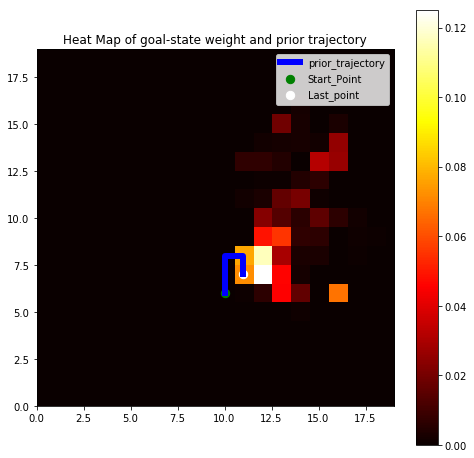

In [194]:
draw_heat_map(test_data[10][:-15],train_data,0.1,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

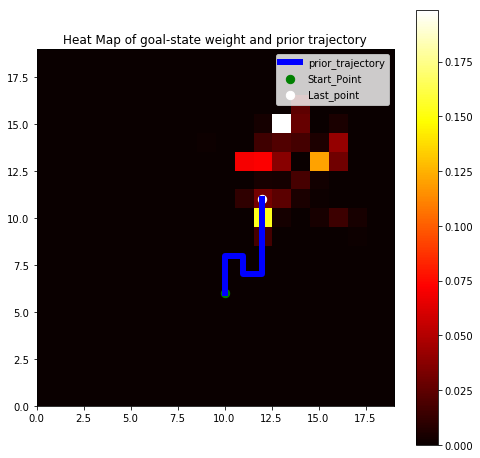

In [195]:
draw_heat_map(test_data[10][:-10],train_data,0.1,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

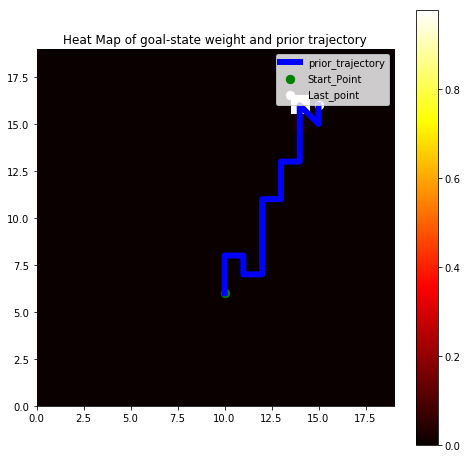

In [198]:
draw_heat_map(test_data[10][:-1],train_data,0.1,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

### 5.1.2 Synthetic Data

In [174]:
Goal_state_label = get_goal_state_label(200,400,train_data_synthetic)
adjacent_state = get_adjacent_state_matrix() 
T_res = get_specific_goal_transition(train_data_synthetic,400,Goal_state_label,adjacent_state,0.1)
initial_state_probability = get_initial_state_probability(train_data_synthetic,400,0.1)
frequency = P_T_frequency(400,400,train_data_synthetic)

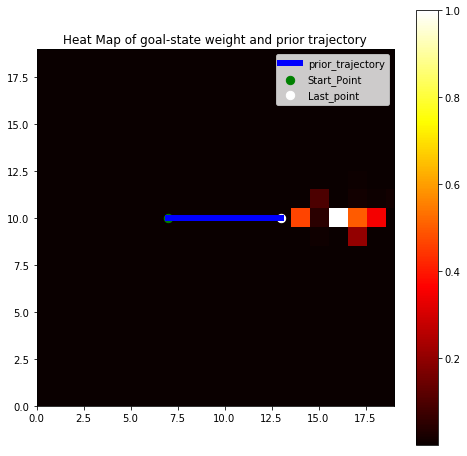

In [179]:
draw_heat_map([150,170,190,210,230,250,270],train_data_synthetic,0.1,adjacent_state,Goal_state_label,T_res,initial_state_probability,frequency)

## 5.2 Heat map of Goal State distribution

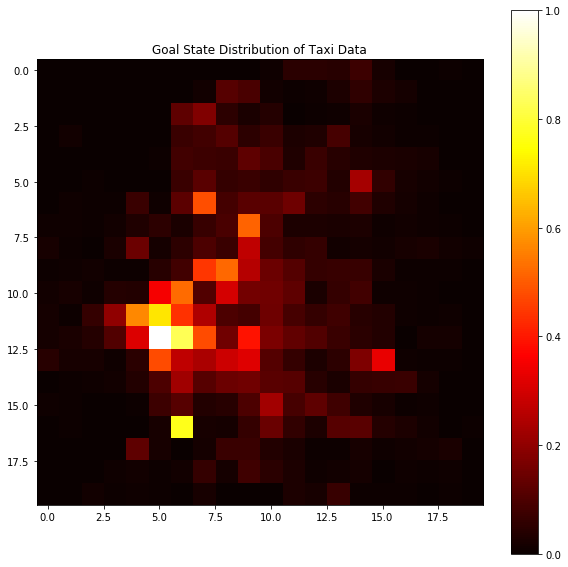

In [152]:
plt.figure(figsize=(10,10))
heat_map = np.reshape(get_goal_state_distribution(data),(20,20))
heat_map =heat_map/heat_map.max()
plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Goal State Distribution of Taxi Data')
plt.show()